In [6]:
filters_path = '../metadata/dsets.csv'
dataset_str = 'Zuani_2024_LUAD'
adatas_path = '/root/datos/maestria/netopaas/luca/data/'


data_dir = '/root/datos/maestria/netopaas/lung_scRNA/'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries/'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import scanpy as sc

 captum (see https://github.com/pytorch/captum).


ModuleNotFoundError: No module named 'GEOparse'

In [4]:
dataset_str

'Zuani_2024_NSCLC'

In [7]:
filters = pd.read_csv(filters_path)
id_row = filters[filters.id == dataset_str]
# file_str = '/'.join(id_row.input_adata.iloc[0].split('/')[1:])
file_str = id_row.input_adata.iloc[0]

thresholds = {}
thresholds['min_counts']  = int(id_row.min_counts)
thresholds['max_counts'] = int(id_row.max_counts)
thresholds['min_genes'] = int(id_row.min_genes)
thresholds['max_genes'] = int(id_row.max_genes)
thresholds['max_pct_mito'] = int(id_row.max_pct_mito)

adata = ad.read_h5ad(file_str)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
#papermill_description=FILTERS

# very basic gene filtering - genes with 0 cells cause some downstream processes to fail.
print("Filtering genes")
print(f"    Before: {adata.shape[1]}")
sc.pp.filter_genes(adata, min_counts=2)
print(f"    After: {adata.shape[1]}")

# %%
# Apply thresholds
print("Filter by min_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_counts=thresholds["min_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_counts=thresholds["max_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by min_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_genes=thresholds["min_genes"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_genes=thresholds["max_genes"])
print(f"    After: {adata.shape[0]}")

# %%
if "mito" not in adata.var.columns:
    adata.var["mito"] = adata.var_names.str.lower().str.startswith("mt-")

# %%
sc.pp.calculate_qc_metrics(
    adata, qc_vars=("mito",), log1p=False, inplace=True, percent_top=None
)

print("Filter by max_pct_mito")
print(f"    Before: {adata.shape[0]}")
adata = adata[adata.obs["pct_counts_mito"] < thresholds["max_pct_mito"]].copy()
print(f"    After: {adata.shape[0]}")

Filtering genes
    Before: 33538


/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    After: 29955
Filter by min_counts
    Before: 312502


/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    After: 270340
Filter by max_counts
    Before: 270340
    After: 270233
Filter by min_genes
    Before: 270233


/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    After: 270067
Filter by max_genes
    Before: 270067
    After: 265963
Filter by max_pct_mito
    Before: 265963
    After: 220866


/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata.write_h5ad(f'{backup_dir}/filtered_{dataset_str}.h5ad')

In [4]:
adata = ad.read_h5ad(f'{backup_dir}/filtered_{dataset_str}.h5ad')
adata

/usr/local/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


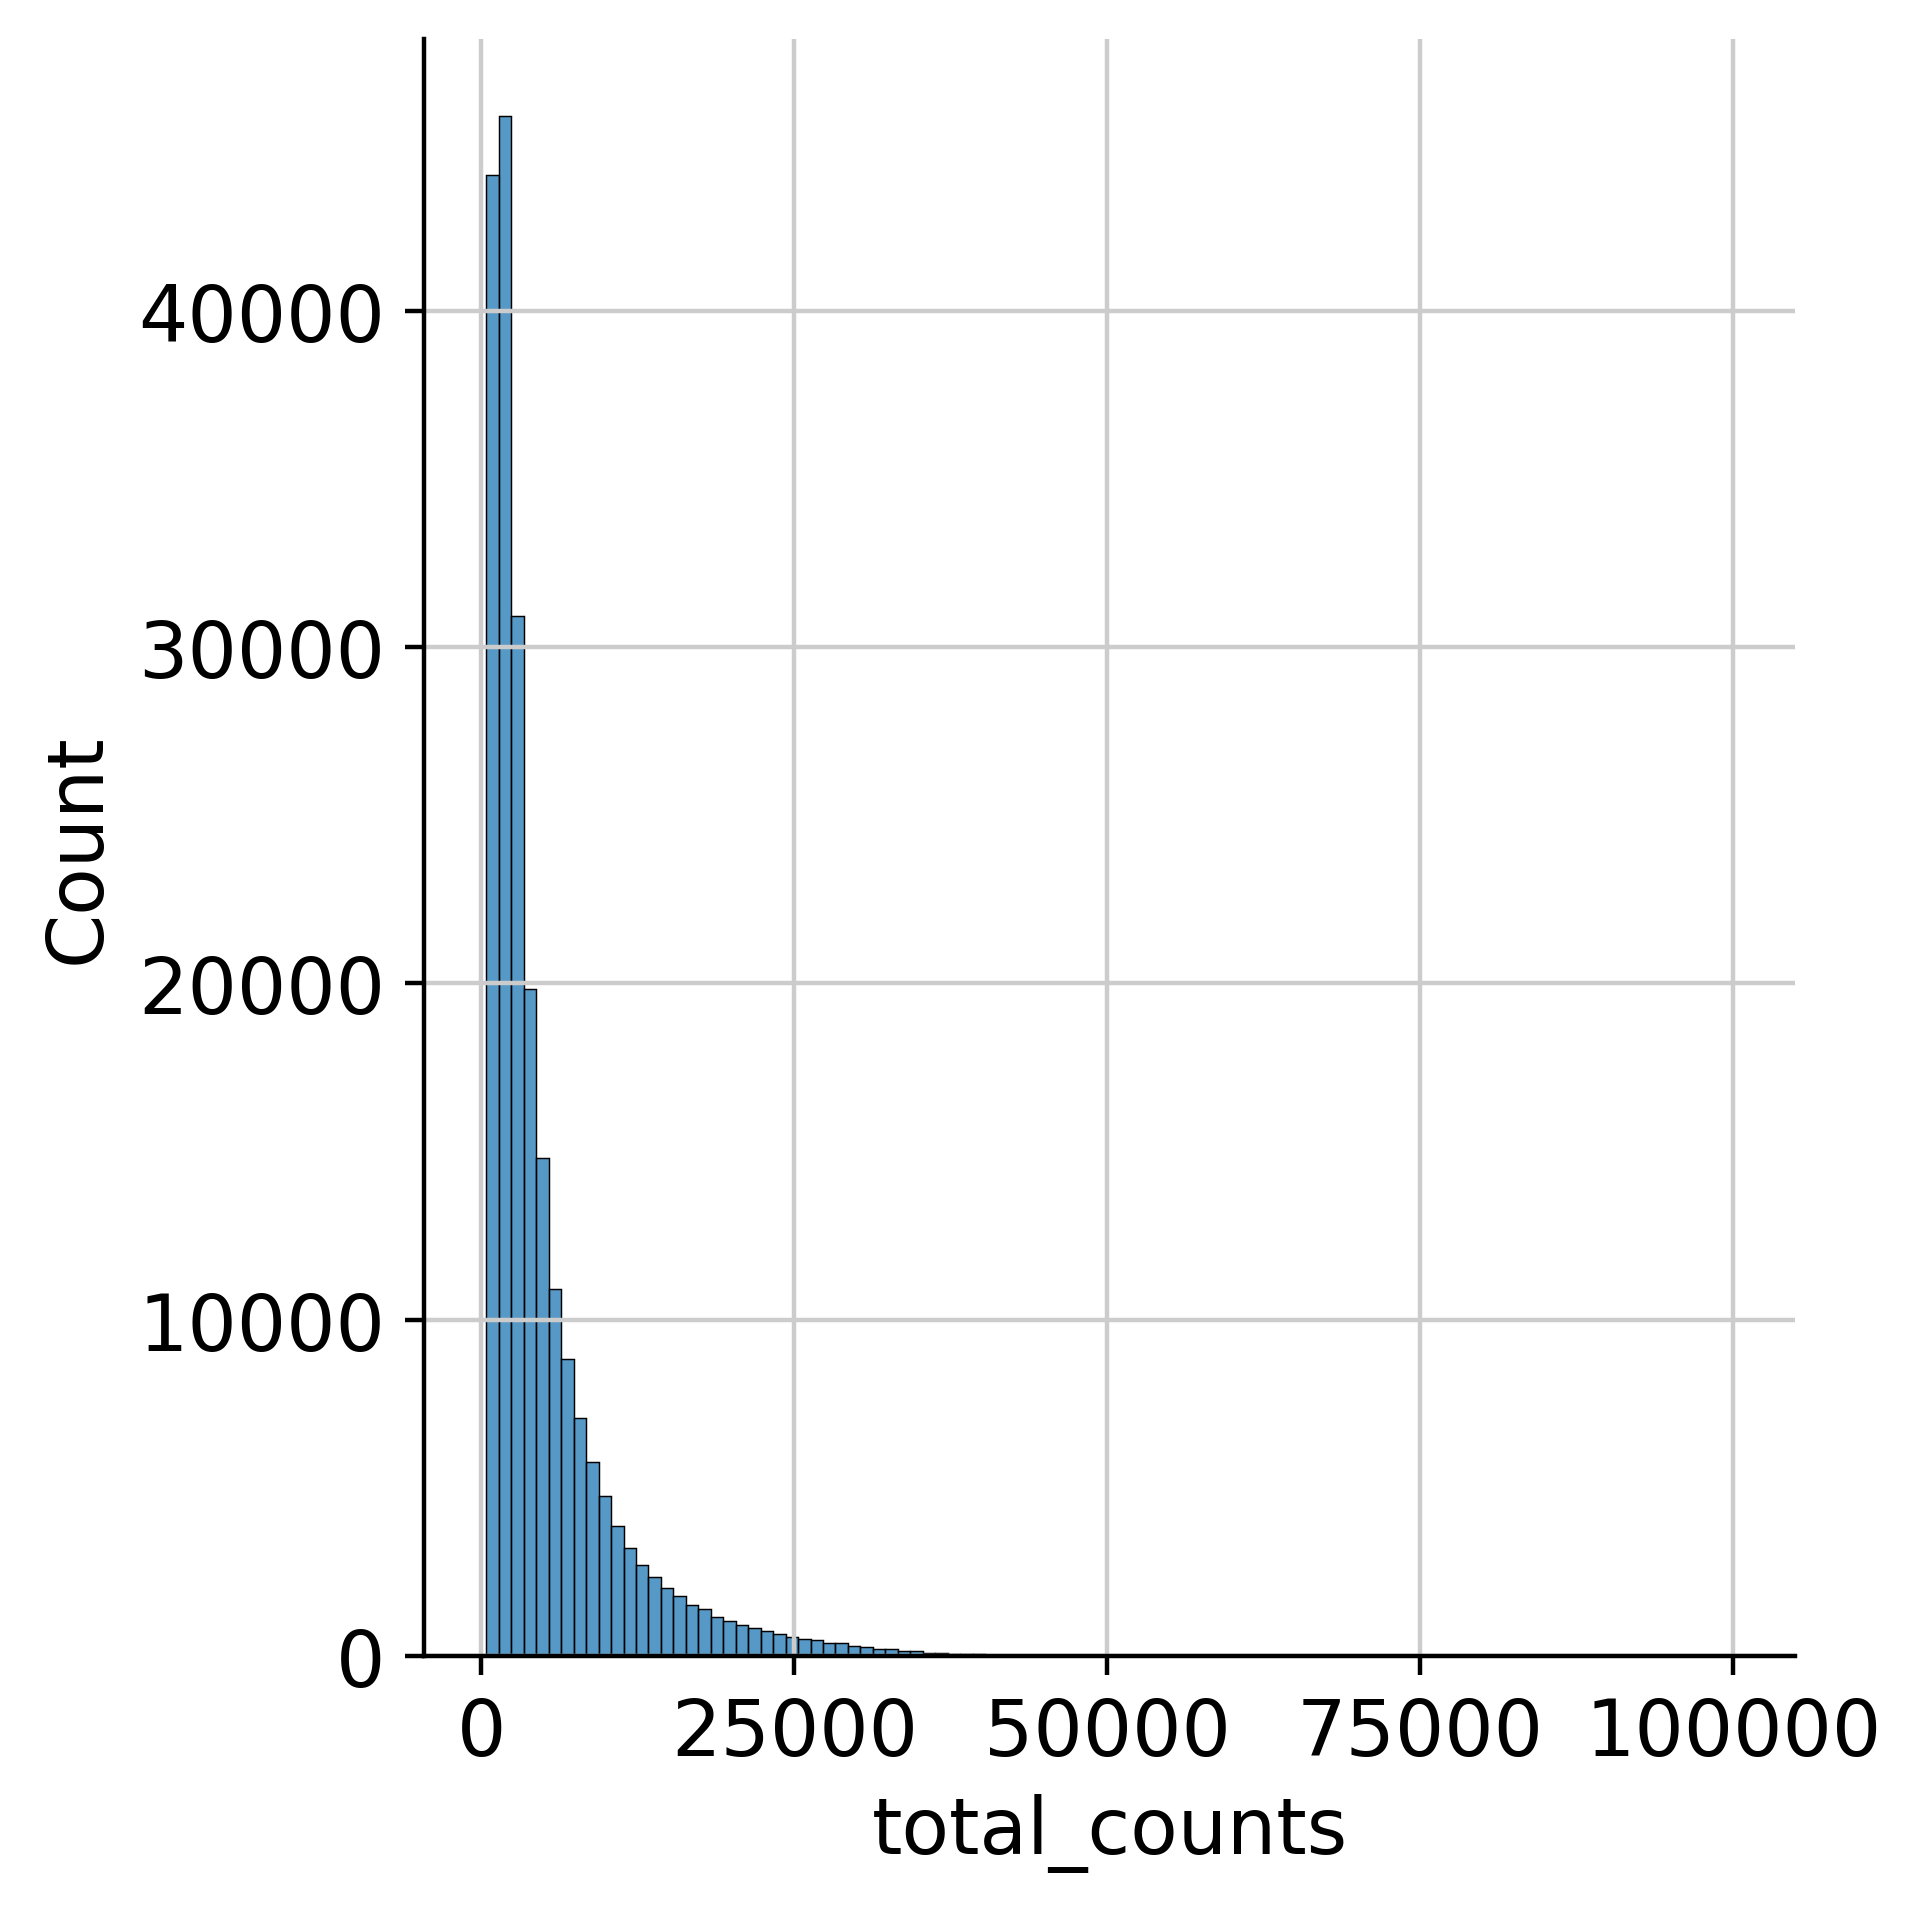

In [10]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)

## convert tu emsembl id (unnecessary)

In [18]:
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

# Set the graphics device
robjects.r('options(bitmapType="cairo")')
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_190101/4289007373.py:16: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [10]:
gene_names = list(adata.var.index)

In [47]:
%%R -i gene_names -o ens38 -o ens37
# extids <- c("AL627309.1","MIR1302-2HG","ENSG00000243485")
library(biomaRt)

extids <- gene_names

ensembl38 <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl",
                        mirror = "useast")
ensembl37 <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl",
                        mirror = "useast", version='GRCh37')

ens38 <- getBM(attributes = c('ensembl_gene_id','external_gene_name'),
      filters = 'external_gene_name',
      values = extids, 
      mart = ensembl38)
ens37 <- getBM(attributes = c('ensembl_gene_id','external_gene_name'),
      filters = 'external_gene_name',
      values = extids, 
      mart = ensembl37)

In [38]:
adata.var['symbol'] = adata.var.index

In [96]:
miau = pd.merge(adata.var.loc[:,['symbol']], ens37, left_on='symbol', right_on='external_gene_name', how='left')
miau = miau.drop_duplicates('symbol')
miau.index = miau.symbol
adata.var['ensembl_gene_id1'] = miau['ensembl_gene_id'].copy()

In [95]:
miau = pd.merge(adata.var.loc[:,['symbol']], ens38, left_on='symbol', right_on='external_gene_name', how='left')
miau = miau.drop_duplicates('symbol')
miau.index = miau.symbol
adata.var['ensembl_gene_id2'] = miau['ensembl_gene_id'].copy()

In [97]:
adata.var['ensembl_gene_id'] = adata.var['ensembl_gene_id2'].combine_first(adata.var['ensembl_gene_id1'])

In [98]:
adata.var['ensembl_gene_id1'].isna().sum()

9515

In [99]:
adata.var['ensembl_gene_id2'].isna().sum()

8990

In [100]:
zuani_ensembl = adata.var.loc[:,['symbol', 'ensembl_gene_id']]
zuani_ensembl.to_csv('/root/datos/maestria/netopaas/zuani_ensembl.csv')